# LoRA desde Cero con NumPy (Notebook Didáctico)

**Objetivo:** Entender y **reproducir** Low-Rank Adaptation (LoRA) solo con **NumPy**, con ejemplos pequeños y ejercicios.



## Índice
1. [¿Qué es LoRA?](#que-es-lora)
2. [Formulación algebraica](#formulacion)
3. [Implementación NumPy de un parche LoRA](#numpy-lora)
4. [Ejemplo numérico paso a paso](#ejemplo-numerico)
5. [Entrenamiento: una actualización de gradiente](#update-gradiente)
6. [Ahorro de parámetros vs. rango _r_](#param-savings)
7. [Fusión para inferencia (merge)](#merge)
8. [Mini-proyecto: clasificador lineal con y sin LoRA](#mini-proyecto)
9. [Ejercicios](#ejercicios)
10. [Exportar a PDF / Compartir](#exportar)


## 1. Introducción: Modelos, pesos y fine-tuning

Antes de hablar de **LoRA**, necesitamos entender el escenario donde se utiliza.

---

### 📌 ¿Qué es un modelo LLM?
Un *Large Language Model* (LLM) es un programa entrenado para **predecir la siguiente palabra o token** en un texto, después de haber visto miles de millones de ejemplos.  
Internamente, está compuesto por **capas** de redes neuronales que transforman la información paso a paso, desde la entrada hasta la salida.

---

### 🔢 ¿Qué son los pesos ($W$) y el sesgo (*bias*, $b$)?
En cada capa de una red neuronal hay dos elementos clave:

1. **Pesos ($W$)**  
   - Son números organizados en forma de **matriz**.  
   - Le dicen a la capa *cómo* debe transformar la información que recibe.  
   - Cada fila y columna controla una parte distinta de la transformación.

2. **Sesgo (*bias*, $b$)**  
   - Es un vector que se **suma** después de multiplicar por $W$.  
   - Sirve para **desplazar** el resultado y darle más flexibilidad.  
   - Sin $b$, todas las transformaciones pasarían por el origen (0,0,...), lo que limita lo que la red puede aprender.

Si llamamos:
- $x$: vector de entrada (información que llega a la capa)
- $W$: matriz de pesos
- $b$: vector de sesgo

La operación matemática de la capa (sin funciones no lineales) es:
$$
y = W \, x + b
$$

---

### 🎯 ¿Qué efecto tiene multiplicar $W$ por $x$?
Multiplicar una **matriz** por un **vector** es aplicar una **transformación lineal**. Esto puede:
1. **Escalar** → hacer que el vector sea más largo o más corto.
2. **Rotar / inclinar** → cambiar su dirección.
3. **Combinar componentes** → mezclar información de las distintas dimensiones de entrada.

El sesgo $b$ luego desplaza el resultado, moviéndolo a otra posición en el espacio.

---

### 🔍 Ejemplo intuitivo
Imagina $x$ como una **flecha** dibujada sobre una hoja:
- $W$ puede **girar** esa flecha, **estirarla**, **encogerla** o **aplastarla** hacia una línea o plano.
- $b$ moverá la flecha entera a otra parte del papel, sin cambiar su forma ni orientación.

---

### 📚 En redes neuronales y modelos de lenguaje
- En redes neuronales:
  - $x$ = información que proviene de la capa anterior.
  - $W$ = define cómo esa información se transforma.
  - $b$ = ajusta y desplaza el resultado final.
- En un LLM:
  - $x$ = representación numérica (*embedding*) de una palabra o token.
  - $W$ = pesos que convierten esa representación en otra más útil para la siguiente capa.
  - Cambiar la **dirección** es como cambiar el “sentido” que el modelo percibe del contexto.
  - Cambiar la **escala** es como ajustar la importancia de ciertas características.

---

📊 **Ejemplo visual**:  
En la figura, el vector azul es $x$ (original) y el rojo es $y = W x$ después de aplicar la matriz de pesos.  
Observa cómo cambian su **dirección** y su **longitud**.  
El sesgo $b$ no está ilustrado aquí, pero su efecto sería **desplazar** el punto final del vector rojo.

<img src="https://raw.githubusercontent.com/surribasg/Lora/main/imagen/transformaciones_subplots.png" width="400" alt="Transformaciones lineales + bias">


## 1. ¿Qué es LoRA? <a name="que-es-lora"></a>

**Idea clave.**  
En vez de ajustar todos los pesos grandes de una capa (matriz **W**), **congelamos** `W` (no la modificamos) y aprendemos solo una **actualización de bajo rango** (ΔW).

### Fórmula de la actualización
$$
\Delta W = B A
\quad \text{con} \quad
A \in \mathbb{R}^{r \times d}, \;
B \in \mathbb{R}^{k \times r}, \;
r \ll \min(k,d)
$$

#### Significado de cada símbolo:
- **$W$**: matriz de pesos original de la capa (dimensión $k \times d$).  
  - $k$ = número de neuronas de salida (o tamaño de vector de salida).  
  - $d$ = número de neuronas de entrada (o tamaño de vector de entrada).
- **$\Delta W$**: "parche" que vamos a añadir a $W$ para adaptarlo.
- **$A$**: matriz entrenable de tamaño $r \times d$.  
  - Reduce la dimensionalidad de entrada de $d$ a $r$.
- **$B$**: matriz entrenable de tamaño $k \times r$.  
  - Vuelve a expandir de $r$ a $k$.
- **$r$**: *rango* del parche LoRA. Es mucho más pequeño que $k$ o $d$ para reducir parámetros y coste computacional.

El **peso efectivo** después de aplicar LoRA es:
$$
W_{\text{eff}} = W + \Delta W = W + B A
$$

> En palabras: usamos dos matrices pequeñas ($A$ y $B$) para construir una actualización $\Delta W$ que se suma a los pesos originales $W$.

---

**Ventajas:**
- Mucho menos memoria y cálculo que ajustar todos los pesos.
- Resultados competitivos en tareas de fine-tuning.

**Uso típico:**
- Parchear capas `Linear` (proyecciones en Transformers) sin modificar la arquitectura del modelo.



## 2. Formulación algebraica <a name="formulacion"></a>

Partimos de una **capa lineal**:

- **Sin LoRA**:  
$$
y = W \, x + b
$$

- **Con LoRA**:  
$$
y = (W + B A) \, x + b
$$

### Significado de cada símbolo
- $x$: vector de entrada de tamaño $d$.
- $y$: vector de salida de tamaño $k$.
- $W$: matriz de pesos original ($k \times d$), **congelada** en LoRA.
- $b$: vector de sesgo (*bias*) de tamaño $k$.
- $A$: matriz entrenable de tamaño $r \times d$.
- $B$: matriz entrenable de tamaño $k \times r$.

### Durante el entrenamiento:
- **Solo** se actualizan $A$ y $B$.
- $W$ se mantiene fijo (no se ajusta).

### En inferencia:
Podemos **fusionar** el parche en $W$ una sola vez para ahorrar cálculo:
$$
W \leftarrow W + B A
$$
y luego usar la forma estándar:
$$
y = W \, x + b
$$


## 3. Implementación NumPy de un parche LoRA <a name="numpy-lora"></a>

Vamos a implementar utilidades mínimas en **NumPy** para trabajar con LoRA.

### Funciones que crearemos:
1. **`make_lora_patch`**:  
   Genera dos matrices entrenables $A$ y $B$ para una matriz base $W$.
   - $A$: tamaño $r \times d$ (reduce la dimensión).
   - $B$: tamaño $k \times r$ (vuelve a expandir).

2. **`weff(W, A, B)`**:  
   Calcula el **peso efectivo**:
   $$
   W_{\text{eff}} = W + B A
   $$

3. **`merge_into(W, A, B)`**:  
   Devuelve una copia de $W$ con el parche **fusionado** para uso en inferencia:
   $$
   W \leftarrow W + B A
   $$

> 💡 Recuerda: en LoRA, **$W$ está congelada** durante el entrenamiento. Solo se ajustan $A$ y $B$.



In [ ]:
import numpy as np

def set_seed(seed=42):
    rng = np.random.default_rng(seed)
    return rng

def make_lora_patch(k, d, r, rng, scale=1e-3):
    """Crea matrices A (r x d) y B (k x r) con inicialización pequeña."""
    A = rng.normal(0, scale, size=(r, d))
    B = rng.normal(0, scale, size=(k, r))
    return A, B

def weff(W, A, B):
    return W + B @ A

def merge_into(W, A, B):
    """Devuelve una copia fusionada: W + B@A."""
    return W + B @ A


## 4. Ejemplo numérico paso a paso <a name="ejemplo-numerico"></a>
Usaremos dimensiones pequeñas para **ver** los números y construir intuición.


In [ ]:
rng = set_seed(0)
k, d, r = 4, 4, 2
W = np.array([[1, 0, -1, 2],
              [0, 1,  1,-1],
              [2,-2,  0, 0],
              [1, 1,  1, 1]], dtype=float)

A = np.array([[ 0.1,  0.2,  0.3,  0.4],
              [-0.1, -0.2,  0.0,  0.1]])

B = np.array([[ 1.0,  0.0],
              [ 0.0,  1.0],
              [ 0.5, -0.5],
              [-1.0,  1.0]])

dW = B @ A
W_eff = weff(W, A, B)

print("ΔW =\n", dW)
print("W_eff =\n", W_eff)

## 5. Entrenamiento: una actualización de gradiente <a name="update-gradiente"></a>
Simulamos **una** actualización por descenso de gradiente con loss de error cuadrático medio (MSE) sobre una sola muestra:
- Entrada \(x \in \mathbb{R}^d\)
- Objetivo \(y^{true} \in \mathbb{R}^k\)
- \(y = W_{eff} x\), \(L = \tfrac{1}{2}\lVert y - y^{true} \rVert^2\)

Derivadas (sin sesgo para simplificar):
- Sea \(e = y - y^{true}\). Entonces \(\frac{\partial L}{\partial y} = e\).
- \(y = (W + BA) x\) ⇒ \(\frac{\partial L}{\partial (BA)} = e \cdot x^\top\).
- Usando \(\Delta W = BA\) con producto de matrices:
  - \(\frac{\partial L}{\partial A} = B^\top \; \frac{\partial L}{\partial (BA)} = B^\top e x^\top\)
  - \(\frac{\partial L}{\partial B} = \frac{\partial L}{\partial (BA)} A^\top = e x^\top A^\top\)

Actualizamos: \(A \leftarrow A - \alpha \nabla_A\), \(B \leftarrow B - \alpha \nabla_B\).  
**Nota:** \(W\) permanece congelada.


In [ ]:
def lora_step(W, A, B, x, y_true, lr=0.1):
    # forward
    y = (W + B @ A) @ x
    e = y - y_true
    loss = 0.5 * np.sum(e**2)

    # grads
    # dL/d(BA) = e x^T  (outer product)
    outer = np.outer(e, x)  # shape (k, d)
    dA = B.T @ outer        # (r, d)
    dB = outer @ A.T        # (k, r)

    # update
    A_new = A - lr * dA
    B_new = B - lr * dB
    return A_new, B_new, loss, y

# Prueba con una muestra
x = np.array([1,0,0,0], dtype=float)  # selecciona la primera columna
y_true = np.ones(k)

A_new, B_new, loss_before, y_pred_before = lora_step(W, A, B, x, y_true, lr=0.1)

W_eff_new = weff(W, A_new, B_new)
y_pred_after = W_eff_new @ x
loss_after = 0.5 * np.sum((y_pred_after - y_true)**2)

print("Loss antes:", loss_before)
print("Predicción antes:", y_pred_before)
print("Loss después:", loss_after)
print("Predicción después:", y_pred_after)

## 6. Ahorro de parámetros vs. rango _r_ <a name="param-savings"></a>
Para una capa \(W \in \mathbb{R}^{k \times d}\), LoRA añade \(r(k + d)\) parámetros en lugar de \(k\cdot d\).
Graficamos la relación al variar \(r\).


In [ ]:
import matplotlib.pyplot as plt

def lora_params(k, d, r):
    return r*(k+d)

def full_params(k, d):
    return k*d

def plot_param_savings(k=4096, d=4096, r_values=(2,4,8,16,32,64,128)):
    full = full_params(k,d)
    lora_list = [lora_params(k,d,r) for r in r_values]
    ratios = [lp/full for lp in lora_list]

    plt.figure()
    plt.plot(r_values, lora_list, marker='o', label='LoRA params')
    plt.plot(r_values, [full]*len(r_values), linestyle='--', label='Full params')
    plt.xlabel("r (rango)")
    plt.ylabel("Número de parámetros")
    plt.title("Parámetros: LoRA vs. Full para una capa")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(r_values, ratios, marker='o', label='LoRA / Full')
    plt.xlabel("r (rango)")
    plt.ylabel("Proporción (LoRA / Full)")
    plt.title("Proporción de parámetros vs. r")
    plt.legend()
    plt.show()

plot_param_savings()

## 7. Fusión para inferencia (merge) <a name="merge"></a>
En producción, podemos **fusionar** una vez el parche: \(W \leftarrow W + BA\).  
Eso elimina el coste adicional del parche durante el forward.


In [ ]:
W_merged = merge_into(W, A_new, B_new)
np.allclose(W_merged, weff(W, A_new, B_new))

## 8. Mini-proyecto: clasificador lineal con y sin LoRA <a name="mini-proyecto"></a>
Comparamos **entrenar todos los pesos** vs **solo LoRA** en un problema sencillo de clasificación (2 clases) usando **NumPy**.


In [ ]:
# Dataset sintético 2D -> 2 clases (linealmente separable con ruido)
rng = set_seed(123)
n = 400
X = rng.normal(size=(n, 2))
w_true = np.array([[2.0, -1.0],
                   [-2.0,  1.0]])  # mapea 2->2
b_true = np.array([0.5, -0.5])
Y_scores = X @ w_true.T + b_true
y = (Y_scores[:, 0] > Y_scores[:, 1]).astype(int)  # argmax a 2 clases

# One-hot
K = 2
Y = np.zeros((n, K))
Y[np.arange(n), y] = 1.0

# Modelo lineal: y = softmax(Wx + b); Entrenaremos con CE.
def softmax(z):
    z = z - z.max(axis=1, keepdims=True)
    ez = np.exp(z)
    return ez / ez.sum(axis=1, keepdims=True)

def ce_loss(probs, Ytrue):
    # cross-entropy promedio
    eps = 1e-12
    return -np.mean(np.sum(Ytrue * np.log(probs + eps), axis=1))

def accuracy(probs, Ytrue):
    return np.mean(np.argmax(probs, axis=1) == np.argmax(Ytrue, axis=1))

# Entrenamiento full
d = 2; k = 2
W_full = rng.normal(0, 0.1, size=(k, d))
b_full = np.zeros(k)

lr = 0.1
epochs = 200
for _ in range(epochs):
    logits = X @ W_full.T + b_full
    P = softmax(logits)
    loss = ce_loss(P, Y)
    # grad W, b
    grad_logits = (P - Y) / n
    grad_W = grad_logits.T @ X
    grad_b = grad_logits.sum(axis=0)
    W_full -= lr * grad_W
    b_full -= lr * grad_b

# Entrenamiento con LoRA: W congelada, solo A,B
W_base = rng.normal(0, 0.1, size=(k, d))  # base congelada
r = 1
A_lora = rng.normal(0, 0.05, size=(r, d))
B_lora = rng.normal(0, 0.05, size=(k, r))
b_lora = np.zeros(k)

lr = 0.3
epochs = 300
for _ in range(epochs):
    W_eff = W_base + B_lora @ A_lora
    logits = X @ W_eff.T + b_lora
    P = softmax(logits)
    loss = ce_loss(P, Y)
    grad_logits = (P - Y) / n
    # dL/dW_eff
    dWeff = grad_logits.T @ X  # shape (k,d)
    # propa a A,B (como antes, pero batcheado)
    dA = B_lora.T @ dWeff
    dB = dWeff @ A_lora.T
    db = grad_logits.sum(axis=0)

    A_lora -= lr * dA
    B_lora -= lr * dB
    b_lora -= lr * db

# Métricas
P_full = softmax(X @ W_full.T + b_full)
P_lora = softmax(X @ (W_base + B_lora @ A_lora).T + b_lora)
print("Accuracy FULL  :", accuracy(P_full, Y))
print("Accuracy LoRA  :", accuracy(P_lora, Y))


## 9. Ejercicios <a name="ejercicios"></a>
1. **Explora el rango \(r\)**: Repite el mini-proyecto variando \(r \in \{1,2,4\}\). ¿Cómo cambia la **tasa de acierto** y el **número de parámetros**?
2. **Verificación numérica de gradientes**: Implementa `finite_diff_grad_A_B` para aproximar gradientes por diferencias finitas y compara con las fórmulas analíticas.
3. **Fusión temprana**: Aplica `merge_into` a mitad de entrenamiento y continúa entrenando con la matriz fusionada. ¿Qué observas?
4. **Regularización**: Añade L2 a A y B. ¿Mejora la estabilidad?
5. **Datasets no lineales**: Genera datos en círculos/espirales y añade una capa no lineal pequeña (ReLU) para comparar.


## 10. Exportar a PDF / Compartir <a name="exportar"></a>
**En Google Colab**:  
1. Ve a **Archivo → Imprimir** y elige **Guardar como PDF**.  
2. O usa **Archivo → Descargar** para guardar `.ipynb` y súbelo a GitHub.  
3. Para un **post de LinkedIn**, usa el texto en `LinkedIn_Post_ES.md` (incluido en el repositorio) y adjunta el PDF.

> Tip: Incluye 2-3 capturas (gráficas y tablas con parámetros vs. r) para aumentar el engagement.


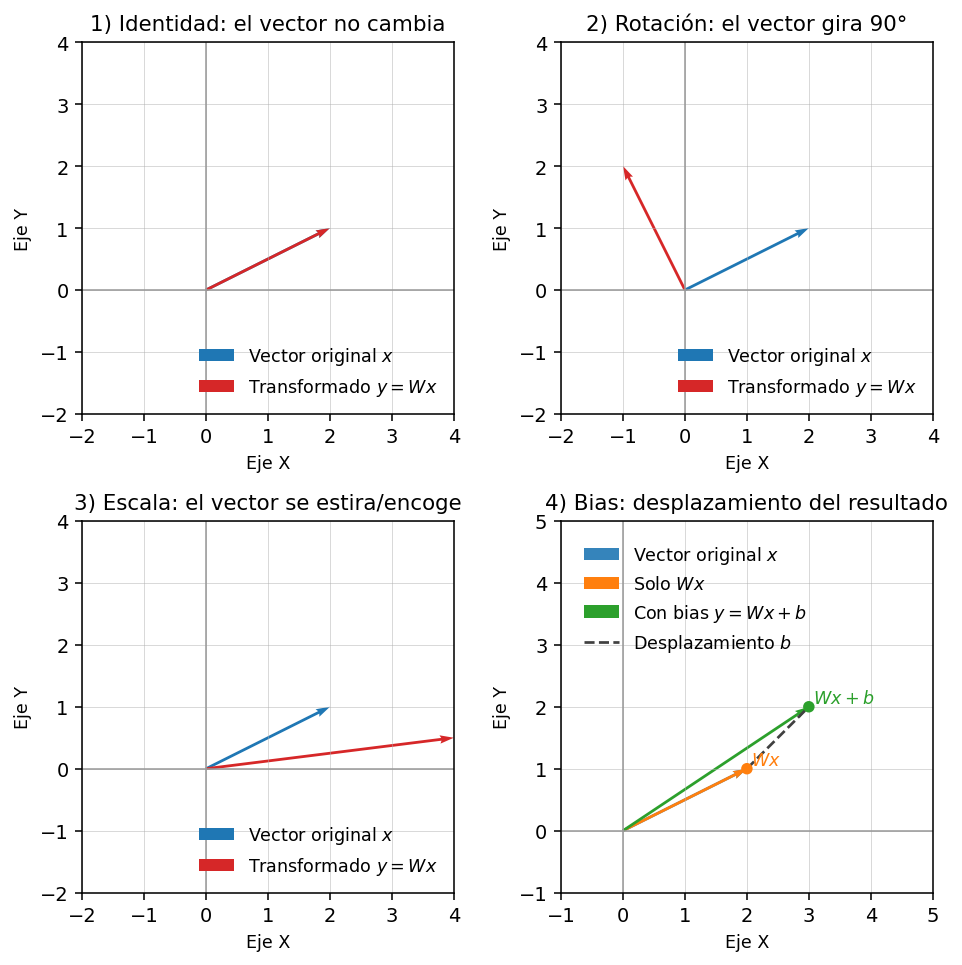

In [10]:
# Transformaciones lineales + bias (subplot 2x2) — versión más clara/compacta
import numpy as np
import matplotlib.pyplot as plt
# plt.ioff()  # <- descomenta si tu entorno parpadea

x = np.array([2.0, 1.0])

W_identidad = np.eye(2)
W_rotacion  = np.array([[0.0, -1.0],
                        [1.0,  0.0]])
W_escala    = np.array([[2.0, 0.0],
                        [0.0, 0.5]])
W_bias      = np.eye(2)
b           = np.array([1.0, 1.0])

y_identidad = W_identidad @ x
y_rotacion  = W_rotacion  @ x
y_escala    = W_escala    @ x
y_bias_lin  = W_bias @ x
y_bias_full = y_bias_lin + b

def draw_from_origin(ax, v, label, color, alpha=1.0):
    ax.quiver(0, 0, v[0], v[1],
              angles='xy', scale_units='xy', scale=1,
              pivot='tail', color=color, alpha=alpha, label=label, linewidth=1.8)

def setup_axes(ax, title, xlim=(-2, 4), ylim=(-2, 4)):
    ax.axhline(0, linewidth=0.8, color='0.6')
    ax.axvline(0, linewidth=0.8, color='0.6')
    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, linewidth=0.4, alpha=0.6)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("Eje X", fontsize=9); ax.set_ylabel("Eje Y", fontsize=9)

fig, axes = plt.subplots(2, 2, figsize=(7, 7), dpi=140)

# 1) Identidad
setup_axes(axes[0, 0], "1) Identidad: el vector no cambia")
draw_from_origin(axes[0, 0], x,           "Vector original $x$", color='tab:blue')
draw_from_origin(axes[0, 0], y_identidad, "Transformado $y=Wx$", color='tab:red')
axes[0, 0].legend(frameon=False, fontsize=9, loc='lower right')

# 2) Rotación
setup_axes(axes[0, 1], "2) Rotación: el vector gira 90°")
draw_from_origin(axes[0, 1], x,          "Vector original $x$", color='tab:blue')
draw_from_origin(axes[0, 1], y_rotacion, "Transformado $y=Wx$", color='tab:red')
axes[0, 1].legend(frameon=False, fontsize=9, loc='lower right')

# 3) Escala
setup_axes(axes[1, 0], "3) Escala: el vector se estira/encoge")
draw_from_origin(axes[1, 0], x,        "Vector original $x$", color='tab:blue')
draw_from_origin(axes[1, 0], y_escala, "Transformado $y=Wx$", color='tab:red')
axes[1, 0].legend(frameon=False, fontsize=9, loc='lower right')

# 4) Bias (mejorado: puntos, etiquetas y desplazamiento claro)
setup_axes(axes[1, 1], "4) Bias: desplazamiento del resultado", xlim=(-1, 5), ylim=(-1, 5))
draw_from_origin(axes[1, 1], x,           "Vector original $x$", color='tab:blue',  alpha=0.9)
draw_from_origin(axes[1, 1], y_bias_lin,  "Solo $Wx$",           color='tab:orange')
draw_from_origin(axes[1, 1], y_bias_full, "Con bias $y=Wx+b$",   color='tab:green')

# Línea de desplazamiento b (Wx -> Wx+b)
axes[1, 1].plot([y_bias_lin[0], y_bias_full[0]],
                [y_bias_lin[1], y_bias_full[1]],
                linestyle='--', linewidth=1.4, color='0.25', label="Desplazamiento $b$")

# Marcas y etiquetas en las puntas
axes[1, 1].scatter([y_bias_lin[0], y_bias_full[0]],
                   [y_bias_lin[1], y_bias_full[1]],
                   s=24, color=['tab:orange', 'tab:green'], zorder=3)
axes[1, 1].text(y_bias_lin[0]+0.06,  y_bias_lin[1]+0.06,  "$Wx$",   color='tab:orange', fontsize=9)
axes[1, 1].text(y_bias_full[0]+0.06, y_bias_full[1]+0.06, "$Wx+b$", color='tab:green',  fontsize=9)

# Leyenda fuera para no tapar el dibujo
axes[1, 1].legend(frameon=False, fontsize=9, loc='upper left', bbox_to_anchor=(0.02, 0.98))

plt.tight_layout()
out = "transformaciones_subplots.png"
plt.tight_layout()
plt.savefig(out, dpi=200, bbox_inches="tight", facecolor="white")
plt.show()

plt.show()


In [11]:
from google.colab import files
files.download("transformaciones_subplots.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>